In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm

# Load and clean prediciton data

In [2]:
df_ground_truth = pd.read_csv('../annotations/ground_truth_boat_frames_coco.csv', index_col=0, sep=';')
df_yolo_predictions = pd.read_csv('../annotations/yolov8x_no_train_labels.csv', index_col=0, sep=';')

df_ground_truth['datetime'] = pd.to_datetime(df_ground_truth.datetime)
df_ground_truth['date'] = df_ground_truth.datetime.dt.date
df_yolo_predictions['datetime'] = pd.to_datetime(df_yolo_predictions['datetime'])
df_yolo_predictions['date'] = pd.to_datetime(df_yolo_predictions.datetime.dt.date, format='%Y-%m-%d')
print('shape of loaded data', df_ground_truth.shape, df_yolo_predictions.shape)
print('Ground truth data:')
print(df_ground_truth.groupby(['date', 'camera_id']).datetime.count())
print('YOLO predictions data:')
print(df_yolo_predictions.groupby(['date', 'camera_id']).datetime.count())

df_yolo_predictions = df_yolo_predictions[\
    ((df_yolo_predictions.date == '2023-06-09') & (df_yolo_predictions.camera_id.isin([1,2]))) |\
    ((df_yolo_predictions.date == '2023-06-10') & (df_yolo_predictions.camera_id == 2)) |\
    ((df_yolo_predictions.date == '2023-07-07') & (df_yolo_predictions.camera_id == 2)) |\
    ((df_yolo_predictions.date == '2023-07-08') & (df_yolo_predictions.camera_id == 1)) \
].copy()

# crop bounding boxes from right side of camera 2 field of view
df_yolo_predictions.drop(index=df_yolo_predictions[(df_yolo_predictions.camera_id == 2) & (df_yolo_predictions.x > 1800)].index, inplace=True)
df_ground_truth.drop(index=df_ground_truth[(df_ground_truth.camera_id == 2) & (df_ground_truth.x > 1800)].index, inplace=True)

df_ground_truth.set_index('filename', inplace=True)
df_yolo_predictions.set_index('filename', inplace=True)

df_ground_truth.shape, df_yolo_predictions.shape

shape of loaded data (25443, 11) (826239, 11)
Ground truth data:
date        camera_id
2023-06-09  1            4149
            2            3481
2023-06-10  2            6321
2023-07-07  2            6500
2023-07-08  1            4992
Name: datetime, dtype: int64
YOLO predictions data:
date        camera_id
2023-06-09  1            214940
            2             12452
2023-06-10  1            132223
            2             28347
2023-06-11  1             65558
            2              5577
2023-07-07  2            189338
2023-07-08  1            177804
Name: datetime, dtype: int64


((24870, 10), (499154, 10))

In [3]:
# filter out predicitons in the bank on camera 1; use a line to define the bank in the camera 1 field of view
point1_cam01_bank = (489, 591)
point2_cam01_bank = (1499, 875)
slope_cam01_bank = (point2_cam01_bank[1] - point1_cam01_bank[1]) / (point2_cam01_bank[0] - point1_cam01_bank[0])
intercept_cam01_bank = point1_cam01_bank[1] - slope_cam01_bank * point1_cam01_bank[0]

def under_the_bank_apply(row):
    if row.camera_id == 1 and row.x >= point1_cam01_bank[0] and row.x <= point2_cam01_bank[0]:
        if row.y > (slope_cam01_bank * row.x + intercept_cam01_bank):
            return True        
    return False
        
df_yolo_predictions['under_the_bank'] = df_yolo_predictions.apply(under_the_bank_apply, axis=1)
print('How many prediction were under the bank?')
print(df_yolo_predictions['under_the_bank'].value_counts())
df_yolo_predictions = df_yolo_predictions[df_yolo_predictions.under_the_bank == False].copy()
print('YOLO predictions filtered data:')
print(df_yolo_predictions.groupby(['date', 'camera_id']).datetime.count())

How many prediction were under the bank?
under_the_bank
True     378526
False    120628
Name: count, dtype: int64
YOLO predictions filtered data:
date        camera_id
2023-06-09  1             5607
            2            11815
2023-06-10  2            27243
2023-07-07  2            67352
2023-07-08  1             8611
Name: datetime, dtype: int64


# Evaluation precision recall of detected frame_ids

In [97]:
def calculate_iou(ground_truth:tuple, prediction:tuple):
    """
        Calculate intersection over union for two bounding boxes.
        Args:
            ground_truth: tuple of (x, y, w, h)
            prediction: tuple of (x, y, w, h)
    """
    gt_xtl = ground_truth[0]-ground_truth[2]/2
    gt_ytl = ground_truth[1]-ground_truth[3]/2
    gt_xbr = ground_truth[0]+ground_truth[2]/2
    gt_ybr = ground_truth[1]+ground_truth[3]/2
    pr_xtl = prediction[0]-prediction[2]/2
    pr_ytl = prediction[1]-prediction[3]/2
    pr_xbr = prediction[0]+prediction[2]/2
    pr_ybr = prediction[1]+prediction[3]/2
    intersection_xtl = max(gt_xtl, pr_xtl)
    intersection_ytl = max(gt_ytl, pr_ytl)
    intersection_xbr = min(gt_xbr, pr_xbr)
    intersection_ybr = min(gt_ybr, pr_ybr)
    intersection_area = max(0, intersection_xbr - intersection_xtl) * max(0, intersection_ybr - intersection_ytl)
    union_area = ground_truth[2] * ground_truth[3] + prediction[2] * prediction[3] - intersection_area
    return intersection_area / union_area

def evaluate_model(df_ground_truth, df_predictions):
    df_predictions_frame_indexed = df_predictions.reset_index().set_index(['filename', 'frame_id'])
    # group quality results by name, aggregate over frame_id and calculate true positive, false positive, false negative when comparing corresponding names and frame from both dataset
    evaluation_dict = dict()
    for id in tqdm.tqdm(set(df_ground_truth.index) | set(df_predictions.index)):
        evaluation_dict[id] = dict()

        if id in df_ground_truth.index:
            if df_ground_truth.loc[id,'frame_id'].size == 1:
                ground_truth_frame_ids = set([df_ground_truth.loc[id,'frame_id']])
            else:
                ground_truth_frame_ids = set(df_ground_truth.loc[id,'frame_id'])
        else:
            ground_truth_frame_ids = set()

        if id in df_predictions.index:
            if df_predictions.loc[id,'frame_id'].size == 1:
                yolo_frame_ids = set([df_predictions.loc[id,'frame_id']])
            else:
                yolo_frame_ids = set(df_predictions.loc[id,'frame_id'])
        else:
            yolo_frame_ids = set()
        
        corresponding_frames = ground_truth_frame_ids & yolo_frame_ids
        evaluation_dict[id]['true_positive'] = len(corresponding_frames)
        evaluation_dict[id]['false_positive'] = len(yolo_frame_ids - ground_truth_frame_ids)
        evaluation_dict[id]['false_negative'] = len(ground_truth_frame_ids - yolo_frame_ids)
        if len(corresponding_frames) > 0:
            frames_iou = {}
            for frame_id in corresponding_frames:
                # calulate iou for each frame
                ground_truth_frame = df_ground_truth.loc[id].loc[df_ground_truth.loc[id].frame_id == frame_id].iloc[0]
                # prediction_frame = df_predictions.loc[id].loc[df_predictions.loc[id].frame_id == frame_id].sort_values('w', ascending=False).iloc[0] ## this line was computation heavy, therefore indexed version is used
                prediciton_frames = df_predictions_frame_indexed.loc[id].loc[frame_id]
                if len(prediciton_frames.shape) == 1:
                    prediction_frame = prediciton_frames
                else:
                    prediction_frame = prediciton_frames.sort_values(['confidence', 'w'], ascending=False).iloc[0]
                frames_iou[frame_id] = calculate_iou(ground_truth_frame[['x', 'y', 'w', 'h']].values, prediction_frame[['x', 'y', 'w', 'h']].values)
            evaluation_dict[id]['iou'] = sum(frames_iou.values()) / len(frames_iou.values())
            evaluation_dict[id]['frames_iou'] = frames_iou
        else:
            evaluation_dict[id]['iou'] = 0
            evaluation_dict[id]['frames_iou'] = []

    df_evaluation = pd.DataFrame().from_dict(evaluation_dict, orient='index')
    df_evaluation['f1'] = 2 * df_evaluation['true_positive'] / (2 * df_evaluation['true_positive'] + df_evaluation['false_positive'] + df_evaluation['false_negative'])
    df_evaluation['recall'] = df_evaluation['true_positive'] / (df_evaluation['true_positive'] + df_evaluation['false_negative'])
    df_evaluation['precision'] = df_evaluation['true_positive'] / (df_evaluation['true_positive'] + df_evaluation['false_positive'])
    
    total_eval = df_evaluation[['true_positive','false_positive','false_negative']].sum(axis=0)
    total_evaluation_dict = {
        'f1': 2*total_eval['true_positive'] / (2*total_eval['true_positive'] + total_eval['false_positive'] + total_eval['false_negative']),
        'recall': total_eval['true_positive'] / (total_eval['true_positive'] + total_eval['false_negative']),
        'precision': total_eval['true_positive'] / (total_eval['true_positive'] + total_eval['false_positive']),
        'iou': (df_evaluation['true_positive']*df_evaluation['iou']).sum() / total_eval['true_positive']
    }
    return df_evaluation, total_evaluation_dict

In [98]:
df_evaluation, total_evaluation_dict = evaluate_model(df_ground_truth, df_yolo_predictions)
total_evaluation_dict

  1%|          | 3/359 [00:00<00:13, 26.46it/s]

100%|██████████| 359/359 [00:38<00:00,  9.24it/s]


{'f1': 0.361082557144987,
 'recall': 0.9386422976501305,
 'precision': 0.22353706996220624,
 'iou': 0.5550109721575143}

In [99]:
df_evaluation.to_csv('data_evaluation.csv', sep=';')

# Confidence values evaluation

In [100]:
confidence_threshold_evaluation_dict = dict()
for confidence_threshold in [0.25, 0.5, 0.75, 0.9]:
    print('Confidence threshold', confidence_threshold)
    df_evaluation, total_evaluation_dict = evaluate_model(df_ground_truth, df_yolo_predictions[df_yolo_predictions.confidence >= confidence_threshold])    
    print(total_evaluation_dict)
    # df_evaluation.to_csv(f'data_evaluation_conf{confidence_threshold}.csv', sep=';')
    confidence_threshold_evaluation_dict[confidence_threshold] = total_evaluation_dict

Confidence threshold 0.25


  2%|▏         | 8/359 [00:00<00:15, 23.09it/s]

100%|██████████| 359/359 [00:38<00:00,  9.38it/s]


{'f1': 0.361082557144987, 'recall': 0.9386422976501305, 'precision': 0.22353706996220624, 'iou': 0.5550109721575143}
Confidence threshold 0.5


100%|██████████| 256/256 [00:29<00:00,  8.68it/s]


{'f1': 0.3953365678049386, 'recall': 0.7795365535248042, 'precision': 0.26481879287644655, 'iou': 0.5778711179232777}
Confidence threshold 0.75


100%|██████████| 217/217 [00:15<00:00, 14.00it/s]


{'f1': 0.43823845327604727, 'recall': 0.4827023498694517, 'precision': 0.4012751814420403, 'iou': 0.6192621243346821}
Confidence threshold 0.9


100%|██████████| 202/202 [00:05<00:00, 36.39it/s]

{'f1': 0.29031706399425383, 'recall': 0.17313968668407312, 'precision': 0.8982010582010582, 'iou': 0.6829156230924763}


Text(0, 0.5, 'Recall')

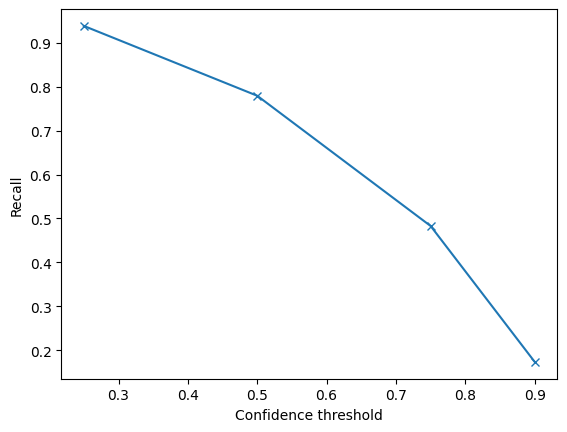

In [89]:
plt.plot(confidence_threshold_evaluation_dict.keys(), [total_evaluation_dict['recall'] for total_evaluation_dict in confidence_threshold_evaluation_dict.values()], 'x-')
plt.xlabel('Confidence threshold')
plt.ylabel('Recall')

Text(0, 0.5, 'F1')

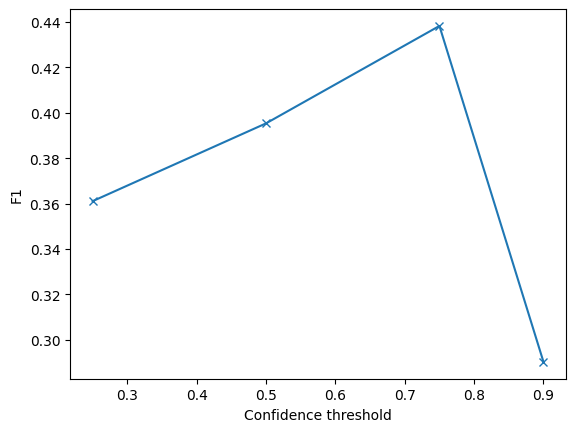

In [88]:
plt.plot(confidence_threshold_evaluation_dict.keys(), [total_evaluation_dict['f1'] for total_evaluation_dict in confidence_threshold_evaluation_dict.values()], 'x-')
plt.xlabel('Confidence threshold')
plt.ylabel('F1')

Text(0, 0.5, 'IOU')

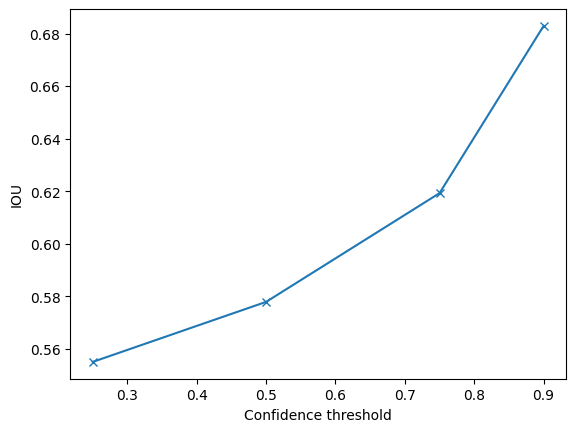

In [94]:
plt.plot(confidence_threshold_evaluation_dict.keys(), [total_evaluation_dict['iou'] for total_evaluation_dict in confidence_threshold_evaluation_dict.values()], 'x-')
plt.xlabel('Confidence threshold')
plt.ylabel('IOU')

# mAP evaluation
- Use https://github.com/bes-dev/mean_average_precision.git for evaluation

In [21]:
# transform coords to xmin, ymin, xmax, ymax
df_ground_truth['xmin'] = (df_ground_truth['x'] - df_ground_truth['w']/2).astype(int)
df_ground_truth['ymin'] = (df_ground_truth['y'] - df_ground_truth['h']/2).astype(int)
df_ground_truth['xmax'] = (df_ground_truth['x'] + df_ground_truth['w']/2).astype(int)
df_ground_truth['ymax'] = (df_ground_truth['y'] + df_ground_truth['h']/2).astype(int)
df_yolo_predictions['xmin'] = (df_yolo_predictions['x'] - df_yolo_predictions['w']/2).astype(int)
df_yolo_predictions['ymin'] = (df_yolo_predictions['y'] - df_yolo_predictions['h']/2).astype(int)
df_yolo_predictions['xmax'] = (df_yolo_predictions['x'] + df_yolo_predictions['w']/2).astype(int)
df_yolo_predictions['ymax'] = (df_yolo_predictions['y'] + df_yolo_predictions['h']/2).astype(int)

## Firt evaluation
- Evaluation only for videos (10 minutes) with known ground truths and predictions
- Missing frames from ground truth or prediction is threated as wrong prediction


In [51]:
metric_fn = MetricBuilder.build_evaluation_metric("map_2d", async_mode=True, num_classes=1)

# for id in tqdm.tqdm(set(df_ground_truth.index) | set(df_yolo_predictions.index)):
for id in tqdm.tqdm(set(df_ground_truth.index) & set(df_yolo_predictions.index)):
    # print(id)
    # TODO there can be an error bcs id not in index
    df_ground_truth_filtered = df_ground_truth.loc[id].set_index('frame_id')
    df_yolo_predictions_filtered = df_yolo_predictions.loc[id].set_index('frame_id')

    # if id in df_ground_truth.index:
    #     if df_ground_truth.loc[id,'frame_id'].size == 1:
    #         ground_truth_frame_ids = set([df_ground_truth.loc[id,'frame_id']])
    #     else:
    #         ground_truth_frame_ids = set(df_ground_truth.loc[id,'frame_id'])
    # else:
    #     ground_truth_frame_ids = set()

    # if id in df_yolo_predictions.index:
    #     if df_yolo_predictions.loc[id,'frame_id'].size == 1:
    #         yolo_frame_ids = set([df_yolo_predictions.loc[id,'frame_id']])
    #     else:
    #         yolo_frame_ids = set(df_yolo_predictions.loc[id,'frame_id'])
    # else:
    #     yolo_frame_ids = set()

    for frame_id in list(df_ground_truth_filtered.index.union(df_yolo_predictions_filtered.index)):
        if frame_id in df_ground_truth_filtered.index:            
            gt = df_ground_truth_filtered.loc[frame_id][['xmin', 'ymin', 'xmax', 'ymax']].values
        else:
            gt = np.array([0, 0, 0, 0])
        if frame_id in df_yolo_predictions_filtered.index:
            preds = df_yolo_predictions_filtered.loc[frame_id][['xmin', 'ymin', 'xmax', 'ymax', 'confidence']].values
        else:
            preds = np.array([0, 0, 0, 0, 0])

        if len(gt.shape) == 1:
            gt = np.array([gt])
        if len(preds.shape) == 1:
            preds = np.array([preds])
        # gt [xmin, ymin, xmax, ymax, class_id, difficult, crowd]
        # preds [xmin, ymin, xmax, ymax, class_id, confidence]
        gt = np.concatenate((gt, np.zeros((gt.shape[0], 3))), axis=1)
        preds = np.concatenate((preds, np.zeros((preds.shape[0], 1))), axis=1)
        preds[:, -1] = preds[:, -2]
        preds[:, -2] = 0

        metric_fn.add(preds, gt)

# compute PASCAL VOC metric
print(f"VOC PASCAL mAP: {metric_fn.value(iou_thresholds=0.5, recall_thresholds=np.arange(0., 1.1, 0.1))['mAP']}")
# compute PASCAL VOC metric at the all points
print(f"VOC PASCAL mAP in all points: {metric_fn.value(iou_thresholds=0.5)['mAP']}")
# compute metric COCO metric
print(f"COCO mAP: {metric_fn.value(iou_thresholds=np.arange(0.5, 1.0, 0.05), recall_thresholds=np.arange(0., 1.01, 0.01), mpolicy='soft')['mAP']}")

  0%|          | 0/193 [00:00<?, ?it/s]

100%|██████████| 193/193 [00:41<00:00,  4.66it/s]


VOC PASCAL mAP: 0.1615930050611496
VOC PASCAL mAP in all points: 0.12525682151317596
COCO mAP: 0.04905642569065094


## Evaluate only for ground truth frames - similar to finetuning procedure

In [ ]:
metric_fn = MetricBuilder.build_evaluation_metric("map_2d", async_mode=True, num_classes=1)

for id in tqdm.tqdm(set(df_ground_truth.index) & set(df_yolo_predictions.index)):
    df_ground_truth_filtered = df_ground_truth.loc[id].set_index('frame_id')
    df_yolo_predictions_filtered = df_yolo_predictions.loc[id].set_index('frame_id')

    for frame_id in list(df_ground_truth_filtered.index):
        if frame_id in df_ground_truth_filtered.index:            
            gt = df_ground_truth_filtered.loc[frame_id][['xmin', 'ymin', 'xmax', 'ymax']].values
        else:
            gt = np.array([0, 0, 0, 0])
        if frame_id in df_yolo_predictions_filtered.index:
            preds = df_yolo_predictions_filtered.loc[frame_id][['xmin', 'ymin', 'xmax', 'ymax', 'confidence']].values
        else:
            preds = np.array([0, 0, 0, 0, 0])

        if len(gt.shape) == 1:
            gt = np.array([gt])
        if len(preds.shape) == 1:
            preds = np.array([preds])
        # gt [xmin, ymin, xmax, ymax, class_id, difficult, crowd]
        # preds [xmin, ymin, xmax, ymax, class_id, confidence]
        gt = np.concatenate((gt, np.zeros((gt.shape[0], 3))), axis=1)
        preds = np.concatenate((preds, np.zeros((preds.shape[0], 1))), axis=1)
        preds[:, -1] = preds[:, -2]
        preds[:, -2] = 0

        metric_fn.add(preds, gt)

# compute PASCAL VOC metric
print(f"VOC PASCAL mAP: {metric_fn.value(iou_thresholds=0.5, recall_thresholds=np.arange(0., 1.1, 0.1))['mAP']}")
# compute PASCAL VOC metric at the all points
print(f"VOC PASCAL mAP in all points: {metric_fn.value(iou_thresholds=0.5)['mAP']}")
# compute metric COCO metric
print(f"COCO mAP: {metric_fn.value(iou_thresholds=np.arange(0.5, 1.0, 0.05), recall_thresholds=np.arange(0., 1.01, 0.01), mpolicy='soft')['mAP']}")

## Evaluate only for ground truth frames - use only validation set

In [59]:
df_ground_truth['date'] = pd.to_datetime(df_ground_truth.datetime.dt.date, format='%Y-%m-%d')
df_ground_truth.shape, df_ground_truth[(df_ground_truth.date == '2023-07-07') | (df_ground_truth.date == '2023-07-08')].shape

((24870, 14), (11248, 14))

In [60]:
metric_fn = MetricBuilder.build_evaluation_metric("map_2d", async_mode=True, num_classes=1)

for id in tqdm.tqdm(set(df_ground_truth[(df_ground_truth.date == '2023-07-07') | (df_ground_truth.date == '2023-07-08')].index) & set(df_yolo_predictions.index)):
    df_ground_truth_filtered = df_ground_truth.loc[id].set_index('frame_id')
    df_yolo_predictions_filtered = df_yolo_predictions.loc[id].set_index('frame_id')

    for frame_id in list(df_ground_truth_filtered.index):
        if frame_id in df_ground_truth_filtered.index:            
            gt = df_ground_truth_filtered.loc[frame_id][['xmin', 'ymin', 'xmax', 'ymax']].values
        else:
            gt = np.array([0, 0, 0, 0])
        if frame_id in df_yolo_predictions_filtered.index:
            preds = df_yolo_predictions_filtered.loc[frame_id][['xmin', 'ymin', 'xmax', 'ymax', 'confidence']].values
        else:
            preds = np.array([0, 0, 0, 0, 0])

        if len(gt.shape) == 1:
            gt = np.array([gt])
        if len(preds.shape) == 1:
            preds = np.array([preds])
        # gt [xmin, ymin, xmax, ymax, class_id, difficult, crowd]
        # preds [xmin, ymin, xmax, ymax, class_id, confidence]
        gt = np.concatenate((gt, np.zeros((gt.shape[0], 3))), axis=1)
        preds = np.concatenate((preds, np.zeros((preds.shape[0], 1))), axis=1)
        preds[:, -1] = preds[:, -2]
        preds[:, -2] = 0

        metric_fn.add(preds, gt)

# compute PASCAL VOC metric
print(f"VOC PASCAL mAP: {metric_fn.value(iou_thresholds=0.5, recall_thresholds=np.arange(0., 1.1, 0.1))['mAP']}")
# compute PASCAL VOC metric at the all points
print(f"VOC PASCAL mAP in all points: {metric_fn.value(iou_thresholds=0.5)['mAP']}")
# compute metric COCO metric
print(f"COCO mAP: {metric_fn.value(iou_thresholds=np.arange(0.5, 1.0, 0.05), recall_thresholds=np.arange(0., 1.01, 0.01), mpolicy='soft')['mAP']}")

  0%|          | 0/84 [00:00<?, ?it/s]

100%|██████████| 84/84 [00:07<00:00, 10.53it/s]


VOC PASCAL mAP: 0.44991669058799744
VOC PASCAL mAP in all points: 0.434072345495224
COCO mAP: 0.14262066781520844


# Helpers for debugging

In [109]:
## cfg_raw_cam_02_fhd_h265_20230609T173000 # there is a car identified as a boat outside of the field of view

In [182]:
def iqr(x):
    return np.percentile(x, 75) - np.percentile(x, 25)
# filter out static bounding box predictions; use iqr < 100 as a threshold and later shift of x coords are less than 10
df_tmp = df_yolo_predictions[df_yolo_predictions.camera_id == 2].reset_index()
df_tmp = df_tmp.groupby('filename').datetime.count()
df_tmp = df_tmp[df_tmp > 100]
df_tmp = df_yolo_predictions.loc[df_tmp.index].reset_index().groupby('filename').agg({'x': iqr, 'y': iqr})
df_static_indexes = df_tmp[(df_tmp.x < 100) & (df_tmp.y < 100)].index

# for each static filename, calculate the shift of x coords between frames and filter out those with shift > 10
for filename in list(df_static_indexes)[5:]:
    print(filename)
    df_tmp = df_yolo_predictions.loc[filename].groupby('frame_id').x.max().reset_index()
    # df_tmp = 
    df_tmp['x_shift'] = df_tmp['x'].diff().abs()
    print(df_tmp)
    # df_tmp = df_tmp[df_tmp['x_shift'] > 10]
    # print(df_tmp)
    # df_static_indexes = df_static_indexes.drop(filename)
    # df_static_indexes = df_static_indexes.append(df_tmp.index)

    break



# .agg({'x': lambda x: np.percentile(x, 75) - np.percentile(x, 25)})

cfg_raw_cam_02_fhd_h265_20230610T125001.mkv
      frame_id     x  x_shift
0            0  1601      NaN
1            1  1602      1.0
2            2  1601      1.0
3            3  1601      0.0
4            4  1601      0.0
...        ...   ...      ...
2342      2395  1410      2.0
2343      2396  1424     14.0
2344      2397  1423      1.0
2345      2398  1412     11.0
2346      2399  1413      1.0

[2347 rows x 3 columns]


In [ ]:
# values for camera 2 bank identification.. this should be the water.. camera have a good horizontal angle, therefore check that bottom coord of bounding box is in upper area of the image y < less than straight line
x = 2 (0.001042), y = 378 (0.350000)
x = 1918 (0.998958), y = 445 (0.412037)

In [180]:
df_tmp.set_index('frame_id').to_csv('debug.csv')

In [141]:
df_tmp.loc['cfg_raw_cam_02_fhd_h265_20230707T202002.mkv']

x    56.0
y     2.0
Name: cfg_raw_cam_02_fhd_h265_20230707T202002.mkv, dtype: float64

<Axes: xlabel='frame_id'>

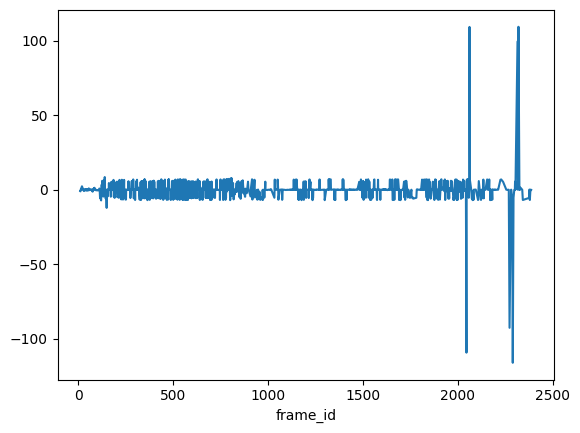

In [150]:
(df_yolo_predictions.loc['cfg_raw_cam_02_fhd_h265_20230707T202002.mkv'].groupby('frame_id').x.max() - df_yolo_predictions.loc['cfg_raw_cam_02_fhd_h265_20230707T202002.mkv'].groupby('frame_id').x.max().shift()).rolling(10).mean().plot()

In [181]:
1597  /4/60

6.654166666666667

In [162]:
df_yolo_predictions.loc['cfg_raw_cam_02_fhd_h265_20230707T202002.mkv'][df_yolo_predictions.loc['cfg_raw_cam_02_fhd_h265_20230707T202002.mkv'].frame_id > 2250].sort_values('frame_id').head(30)

,camera_id,datetime,frame_id,label_class,x,y,w,h,confidence,date,under_the_bank
filename,,,,,,,,,,,
cfg_raw_cam_02_fhd_h265_20230707T202002.mkv,2,2023-07-07 20:20:02,2255,8,1533,828,772,489,0.256372,2023-07-07,False
cfg_raw_cam_02_fhd_h265_20230707T202002.mkv,2,2023-07-07 20:20:02,2265,8,1533,828,773,489,0.304322,2023-07-07,False
cfg_raw_cam_02_fhd_h265_20230707T202002.mkv,2,2023-07-07 20:20:02,2266,8,1533,829,772,490,0.274906,2023-07-07,False
cfg_raw_cam_02_fhd_h265_20230707T202002.mkv,2,2023-07-07 20:20:02,2268,8,1533,828,773,488,0.289129,2023-07-07,False
cfg_raw_cam_02_fhd_h265_20230707T202002.mkv,2,2023-07-07 20:20:02,2272,8,607,763,24,37,0.418604,2023-07-07,False
cfg_raw_cam_02_fhd_h265_20230707T202002.mkv,2,2023-07-07 20:20:02,2280,8,1533,827,772,492,0.278634,2023-07-07,False
cfg_raw_cam_02_fhd_h265_20230707T202002.mkv,2,2023-07-07 20:20:02,2281,8,1533,827,772,491,0.274963,2023-07-07,False
cfg_raw_cam_02_fhd_h265_20230707T202002.mkv,2,2023-07-07 20:20:02,2286,8,1532,826,774,489,0.251022,2023-07-07,False
cfg_raw_cam_02_fhd_h265_20230707T202002.mkv,2,2023-07-07 20:20:02,2289,8,440,852,124,82,0.308547,2023-07-07,False


<Axes: xlabel='frame_id'>

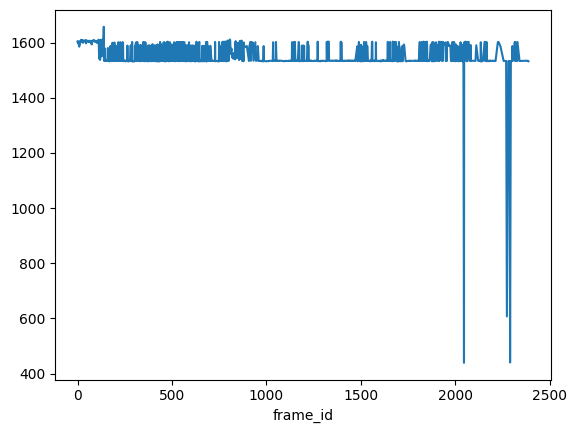

In [147]:
df_yolo_predictions.loc['cfg_raw_cam_02_fhd_h265_20230707T202002.mkv'].groupby('frame_id').x.max().sort_index().plot()

In [112]:
df_yolo_predictions.loc['cfg_raw_cam_02_fhd_h265_20230707T174000.mkv'].y.describe()


count    2586.000000
mean      812.137278
std        84.303707
min       448.000000
25%       832.000000
50%       834.000000
75%       836.000000
max      1065.000000
Name: y, dtype: float64

In [117]:
df_yolo_predictions.loc['cfg_raw_cam_02_fhd_h265_20230707T174000.mkv'].x.value_counts()

x
1533    1123
1534     556
1532     441
1535     170
1536      36
        ... 
1642       1
1617       1
1618       1
1569       1
1072       1
Name: count, Length: 173, dtype: int64

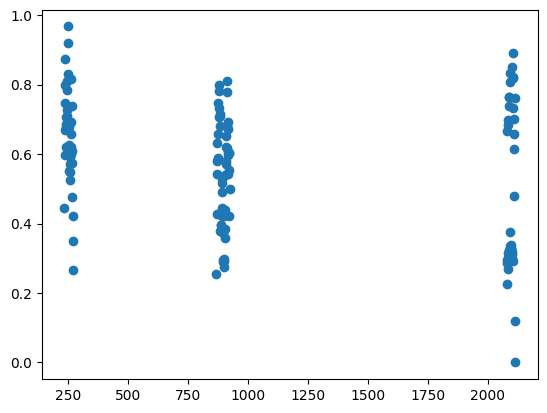

In [48]:
plt.scatter(df_evaluation.iloc[0].frames_iou.keys(), df_evaluation.iloc[0].frames_iou.values())

In [52]:
df_ground_truth.loc['cfg_raw_cam_01_fhd_h265_20230609T050002.mkv'].sort_values('frame_id')

,camera_id,datetime,frame_id,label_class,x,y,w,h,confidance,date
filename,,,,,,,,,,
cfg_raw_cam_01_fhd_h265_20230609T050002.mkv,1,2023-06-09 05:00:02,1087,8,1332,544,187,81,1,2023-06-09
cfg_raw_cam_01_fhd_h265_20230609T050002.mkv,1,2023-06-09 05:00:02,1088,8,1331,542,187,81,1,2023-06-09
cfg_raw_cam_01_fhd_h265_20230609T050002.mkv,1,2023-06-09 05:00:02,1089,8,1332,543,187,81,1,2023-06-09
cfg_raw_cam_01_fhd_h265_20230609T050002.mkv,1,2023-06-09 05:00:02,1090,8,1332,543,187,81,1,2023-06-09
cfg_raw_cam_01_fhd_h265_20230609T050002.mkv,1,2023-06-09 05:00:02,1091,8,1332,543,187,81,1,2023-06-09
cfg_raw_cam_01_fhd_h265_20230609T050002.mkv,1,2023-06-09 05:00:02,1092,8,1332,543,187,81,1,2023-06-09
cfg_raw_cam_01_fhd_h265_20230609T050002.mkv,1,2023-06-09 05:00:02,1093,8,1332,543,187,81,1,2023-06-09
cfg_raw_cam_01_fhd_h265_20230609T050002.mkv,1,2023-06-09 05:00:02,1094,8,1309,554,187,81,1,2023-06-09
cfg_raw_cam_01_fhd_h265_20230609T050002.mkv,1,2023-06-09 05:00:02,1095,8,1310,553,187,81,1,2023-06-09


<Axes: xlabel='filename'>

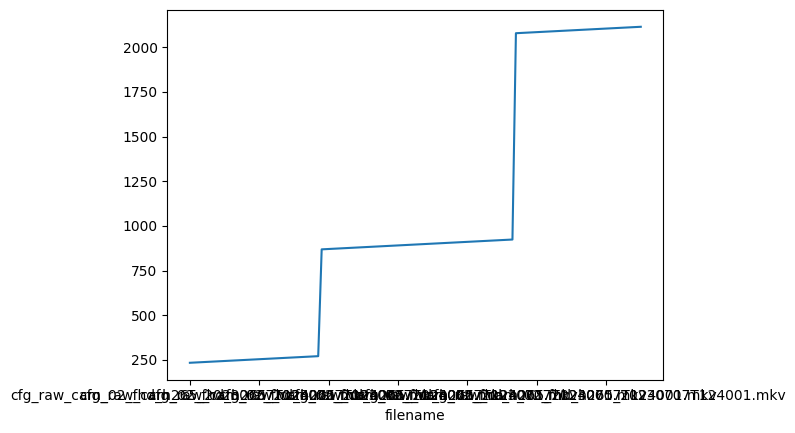

In [24]:
df_ground_truth.loc['cfg_raw_cam_02_fhd_h265_20230707T124001.mkv'].sort_values('frame_id').frame_id.plot()

In [55]:
convert_frame_id = 1087
convert_frame_id / 4 / 60, convert_frame_id / 4 // 60, convert_frame_id / 4 % 60

(4.529166666666667, 4.0, 31.75)

<Axes: xlabel='filename'>

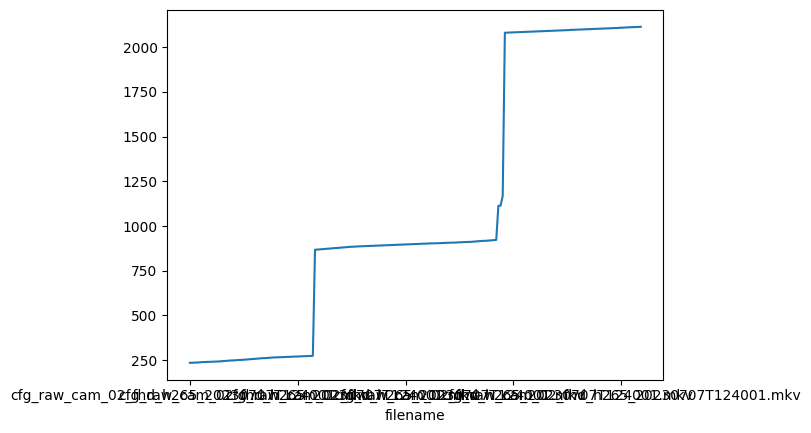

In [29]:
df_tmp = df_yolo_predictions.loc['cfg_raw_cam_02_fhd_h265_20230707T124001.mkv']
df_tmp[df_tmp.x < 1800].sort_values('frame_id').frame_id.plot()